In [1]:
from google.colab import files
uploaded = files.upload()


Saving user-wallet-transactions.json to user-wallet-transactions (1).json


In [3]:
import json

with open('user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

print(f"Total transactions: {len(data)}")


Total transactions: 100000


In [12]:
from collections import defaultdict

wallet_txns = defaultdict(list)

# Group transactions by wallet
for txn in data:
    wallet = txn['userWallet']
    wallet_txns[wallet].append(txn)

wallet_features = []

for wallet, txns in wallet_txns.items():
    deposit_usd = borrow_usd = repay_usd = 0
    liquidations = 0
    borrow_count = repay_count = 0

    for txn in txns:
        action = txn.get('action', '').lower()
        action_data = txn.get('actionData', {})
        raw_amount = float(action_data.get('amount', 0))
        price = float(action_data.get('assetPriceUSD', 1))
        amount_usd = (raw_amount / 1e6) * price  # assuming 6 decimals; adjust if 18

        if action == 'deposit':
            deposit_usd += amount_usd
        elif action == 'borrow':
            borrow_usd += amount_usd
            borrow_count += 1
        elif action == 'repay':
            repay_usd += amount_usd
            repay_count += 1
        elif action == 'liquidationcall':
            liquidations += 1

    repay_borrow_ratio = repay_usd / (borrow_usd + 1e-6)

    wallet_features.append({
        'wallet': wallet,
        'deposit_total': deposit_usd,
        'borrow_total': borrow_usd,
        'repay_total': repay_usd,
        'repay_borrow_ratio': repay_borrow_ratio,
        'liquidations': liquidations
    })

df = pd.DataFrame(wallet_features)


In [13]:
from sklearn.preprocessing import MinMaxScaler

score_input = df[['deposit_total', 'repay_total', 'repay_borrow_ratio']].copy()
score_input['penalty'] = -df['liquidations']

scaler = MinMaxScaler()
score_scaled = pd.DataFrame(scaler.fit_transform(score_input), columns=score_input.columns)

# Weighted sum
df['credit_score'] = (
    0.4 * score_scaled['deposit_total'] +
    0.3 * score_scaled['repay_total'] +
    0.2 * score_scaled['repay_borrow_ratio'] +
    0.1 * score_scaled['penalty']
) * 1000

df['credit_score'] = df['credit_score'].clip(0, 1000).round().astype(int)


In [14]:
print(df[['wallet', 'credit_score']].head())
print("Min score:", df['credit_score'].min(), "Max score:", df['credit_score'].max())


                                       wallet  credit_score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6           100
1  0x000000000051d07a4fb3bd10121a343d85818da6           100
2  0x000000000096026fb41fc39f9875d164bd82e2dc           100
3  0x0000000000e189dd664b9ab08a33c4839953852c           100
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee           101
Min score: 0 Max score: 800


In [15]:
import json

# Convert to dictionary
wallet_scores = dict(zip(df['wallet'], df['credit_score']))

# Save to file
with open('wallet_scores.json', 'w') as f:
    json.dump(wallet_scores, f)


from google.colab import files
files.download('wallet_scores.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

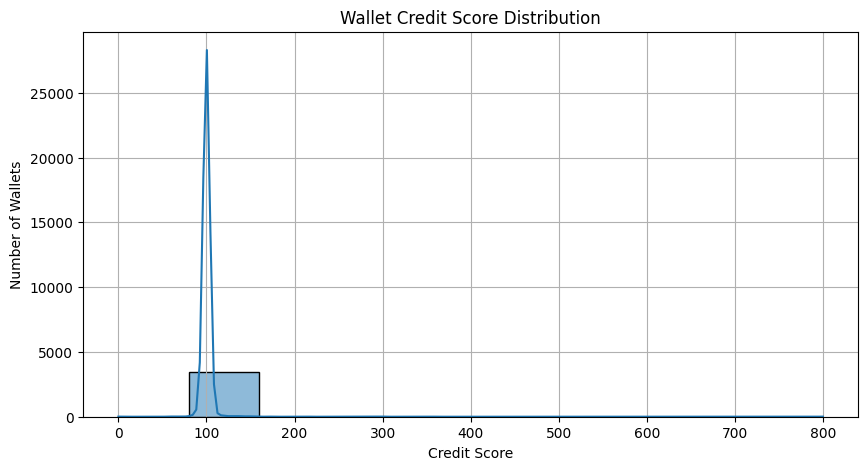

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['credit_score'], bins=10, kde=True)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()
